## Imports

In [1]:
# Pandas, Numpy and Matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import All nltk
import nltk
#nltk.download_shell()

# Get the Data

In [3]:
%%time
# Set name of file
filename = '../data/interim/records.pkl'
#filename = '../data/interim/samples.pkl'

# Read to DataFrame
df = pd.read_pickle(filename)

CPU times: user 21.9 s, sys: 10.1 s, total: 32 s
Wall time: 33.7 s


In [4]:
# Count records with links to PubMed
df[(df['PubMedIds'].apply(len)==0)]['Id'].count()

10536

In [5]:
# Set entries: Choose first N records and count characters in summary
N_entries = 10000
entries = pd.DataFrame(df[['Id','summary']].iloc[:N_entries])
entries['length'] = entries['summary'].apply(len)
entries.head()

,Id,summary,length
0,200000001,This series represents a group of cutaneous ma...,218
1,200000003,We investigated the changes in gene expression...,1289
2,200000010,Human retinal and RPE SAGE libraries. Profile ...,217
3,200000014,This series represents the Cancer Genome Anato...,870
4,200000016,This series represents the data set from the p...,5727


# Separate Train/Test

In [6]:
# Set train/total fraction
train_fraction = 0.5

# Construct mask
mask = np.random.rand(len(entries)) < train_fraction

# Select samples
train_entries = entries[mask]
test_entries = entries[~mask]

# Echo shapes
print('Shapes Train/Test: ', train_entries.shape, test_entries.shape)

Shapes Train/Test:  (5040, 3) (4960, 3)


# Summary Length Analysis

(0, 3000)

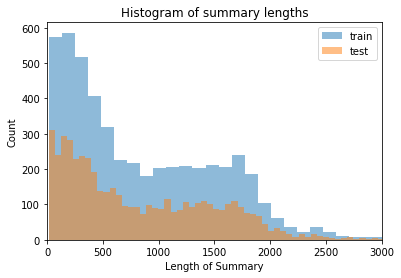

In [7]:
# Grab figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1)

# Plot histograms
train_entries.plot(kind='hist', bins=100, alpha=0.5, ax=axes);
test_entries.plot( kind='hist', bins=100, alpha=0.5, ax=axes);

# Set plotting options
axes.set_xlabel('Length of Summary')
axes.set_ylabel('Count')
axes.set_title('Histogram of summary lengths')
axes.legend(['train','test'])
axes.set_xlim(0,3000)

# Tokenize

In [8]:
# Import tokenizer
from nltk.tokenize import PunktSentenceTokenizer

# Instantiate and Train custom sentence tokenizer
custom_tokenizer = PunktSentenceTokenizer('. '.join(train_entries['summary']))

In [9]:
# Check first sentence
print('_____RAW_____')
print(test_entries['summary'].iloc[0])

print('\n_____TOKENIZE SENTENCES_____')
print(custom_tokenizer.tokenize(test_entries['summary'].iloc[0]))

_____RAW_____
This series represents a group of cutaneous malignant melanomas and unrelated controls which were clustered based on correlation coefficients calculated through a comparison of gene expression profiles. Keywords: other

_____TOKENIZE SENTENCES_____
['This series represents a group of cutaneous malignant melanomas and unrelated controls which were clustered based on correlation coefficients calculated through a comparison of gene expression profiles.', 'Keywords: other']


In [10]:
# Initialize lemmatizer from nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [16]:
# Gather nouns for every summary
from nltk.corpus import stopwords
import string

# Define column names
cols = 'Id Tags'.split()

# Define stopwords
stop_words = set(stopwords.words("English"))

# Define DataFrame
df = pd.DataFrame(columns=cols)

# For every summary
for index, entry in test_entries.iloc[:250].iterrows():
    
    # Initialize list of nouns
    nouns = set()
    
    # Obtain summary and id
    idd = entry['Id']
    summary = entry['summary']
    
    # Sentence-Tokenize every entry
    for sentence in custom_tokenizer.tokenize(summary):
        
        # Word-tokenize every sentence
        words = nltk.word_tokenize(sentence)
        
        # POS tagg every word
        tags = nltk.pos_tag(words)
        
        # From all tags choose only.....
        for tag in tags:
            
            # Get lemmatized version
            lemmatized = lemmatizer.lemmatize(tag[0].lower())
            
            # Is noun ?
            mask1 = tag[1] in 'NN NNS NNP NNPS'.split() 
            
            # Is stop word ?
            mask2 = lemmatized not in stop_words
            
            # Is/Contains punctuation
            mask3 = not bool(set(lemmatized) & set(string.punctuation))
              
            #print(lemmatized, mask1, mask2, mask3, mask1 and mask2 and mask3)
            
            # Only then append
            if mask1 and mask2 and mask3:
                nouns.add(lemmatized)
    
    # Create Record 
    record = pd.Series((idd, nouns),index=cols)
    
    # Append entry to DataFrame
    df = df.append(record,ignore_index=True)

# Echo
df.head()

,Id,Tags
0,200000001,"{comparison, gene, group, expression, coeffici..."
1,200000010,"{human, sage, gene, expression, analysis, rpe,..."
2,200000040,"{human, array, type, plya, microarrays, keywor..."
3,200000041,"{gene, expression, effect, target, keywords, e..."
4,200000043,"{biology, microarrays, protein, antibody, keyw..."


# Create links between #tags in same summary

In [17]:
links = set()
for index, record in df.iterrows():
    for tag1 in record['Tags']:
        for tag2 in record['Tags']:
            links.add((tag1, tag2))
len(links)

190361

In [18]:
import csv

with open('Links_250.csv', 'w') as outfile:
    w = csv.writer(outfile, delimiter=',', quotechar='"')
    w.writerow(['Source','Target'])
    for element in links:
        #print(list(element))
        w.writerow(element)